In [1]:
import time
from petitRADTRANS import Radtrans
import petitRADTRANS.retrieval_examples.emission.master_retrieval_model as rm
from petitRADTRANS import nat_cst as nc
import petitRADTRANS.rebin_give_width as rgw
from scipy.interpolate import interp1d
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
import csv
import pickle
import time

from torch.distributions import Independent, Distribution
from fab_priors import BoxUniform_New

import torch
from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat

In [2]:
retrieval_name = 'JWST_emission_petitRADTRANSpaper'
absolute_path = 'output/'# end with forward slash!
op= '/home/mvasist/petitRADTRANS/petitRADTRANS/retrieval_examples/emission/'
observation_files = {}
observation_files['NIRISS SOSS'] = op +'NIRISS_SOSS_flux.dat'
observation_files['NIRSpec G395M'] = op +'NIRSpec_G395M_flux.dat'
observation_files['MIRI LRS'] = op +'MIRI_LRS_flux.dat'

# Wavelength range of observations, fixed parameters that will not be retrieved
WLEN = [0.3, 15.0]
# LOG_G =  2.58
R_pl = 1.838*nc.r_jup_mean
R_star = 1.81*nc.r_sun
# Get host star spectrum to calculate F_pl / F_star later.
T_star = 6295.
x = nc.get_PHOENIX_spec(T_star)
fstar = interp1d(x[:,0], x[:,1])

In [3]:
####################################################################################
####################################################################################
### READ IN OBSERVATION
####################################################################################
####################################################################################

# Read in data, convert all to cgs! 

'''
Im using only data_flux_nu_error['MIRI LRS'] from here (to calculate the likelihood-paul and rebinning flux-sbi). 
'''

data_wlen = {}
data_flux_nu = {}
data_flux_nu_error = {}
data_wlen_bins = {}

for name in observation_files.keys():
    print(name)
    dat_obs = np.genfromtxt(observation_files[name])
    data_wlen[name] = dat_obs[:,0]*1e-4
    data_flux_nu[name] = dat_obs[:,1]
    data_flux_nu_error[name] = dat_obs[:,2]
    
    data_wlen_bins[name] = np.zeros_like(data_wlen[name])
    data_wlen_bins[name][:-1] = np.diff(data_wlen[name])
    data_wlen_bins[name][-1] = data_wlen_bins[name][-2]

NIRISS SOSS
NIRSpec G395M
MIRI LRS


In [4]:
atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', \
                                         'CO2', 'CH4', \
                                          'Na', 'K'], \
          rayleigh_species = ['H2', 'He'], \
          continuum_opacities = ['H2-H2', 'H2-He'], \
          wlen_bords_micron = [0.3, 15])#, mode='c-k')


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



In [5]:
gravity = np.exp(2.45)


In [6]:
pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

In [7]:
kappa_IR = 0.01
gamma0 = 0.4
T_int0 = 750.
T_equ0 = 2000.

temperature0 = nc.guillot_global(pressures, kappa_IR, gamma0, gravity, T_int0, T_equ0)

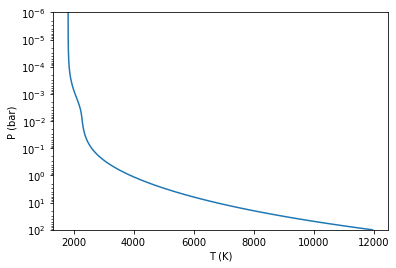

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(temperature0, pressures)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

In [13]:
# with open('/home/mvasist/scripts/T_1M.csv') as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     line_count = 0
#     T=[]
#     for row in csv_reader:
#         T.append([row[1], row[2], row[3]])
#         line_count += 1

# with open('/home/mvasist/scripts/X_1M.csv') as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     line_count = 0
#     X=[]
#     for row in csv_reader:
#         X.append([row[1], row[2], row[3]])
#         line_count += 1

# paul's code

In [8]:
fname1 ='/home/mvasist/samples_paul_MCMC/chain_lnprob_JWST_emission_petitRADTRANSpaper_100w100it_LgmTequLg_U_30.pickle'
with open(fname1, 'rb') as f:
    l1=pickle.load(f)

In [9]:
np.shape(l1)

(1, 100, 100)

In [11]:
lnp = np.array(l1).reshape((10000))

In [12]:
df_lnprob = pd.DataFrame(lnp)

In [13]:
df_lnprob

,0
0,-1.524821e+13
1,-1.524821e+13
2,-1.171944e+13
3,-7.189803e+12
4,-7.189803e+12
...,...
9995,-5.576946e+06
9996,-5.286318e+06
9997,-5.286318e+06
9998,-4.325782e+06


In [13]:
# a=[]
# for i in range(10): 
#      ([df_lnprob[col][i] for col in df_lnprob])

In [14]:
# min(df_lnprob[0])

In [15]:
# use values from posterior samples from paul's mcmc to plot PT profile 

In [14]:
fname2 ='/home/mvasist/samples_paul_MCMC/chain_pos_JWST_emission_petitRADTRANSpaper_100w100it_LgmTequLg_U_30.pickle'
with open(fname2, 'rb') as f:
    lines2 = pickle.load(f)      #pos
    l3= pickle.load(f)           #prob
    l4= pickle.load(f)           #state
    l5= pickle.load(f)           #samples

In [15]:
sampls = l5
np.shape(sampls)
# samples= sampls.reshape((240,50,3))

(10000, 3)

In [16]:
def color_paulMCMC(a):
    mini = min(df_lnprob[0])
    maxi = max(df_lnprob[0])
#     print(a,mini,maxi)
    return (a-mini)/(maxi-mini)*100

In [35]:
#12k - 6 min

In [ ]:
## creating P-T profile for each - takes around 15 min
tem = []
cc=[]
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, figsize=(10,10))
plt.title('Paul MCMC 10k Samples \n log gamma_Tequ_log gravity', fontsize=20)

start = time.time()
c2=0
c4=0
T_int = 750

for i in range(0, 10000):   #np.random.randint
    log_gamma = sampls[i, 0]
    log_gravity = sampls[i, 2]
    T_equ = sampls[i, 1]
    gamma = np.exp(log_gamma)
    gravity = np.exp(log_gravity)
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
    #plotting
    lnprob = [df_lnprob[row][i] for row in df_lnprob][0]
    cc.append(color_paulMCMC(lnprob)) 
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
    ax.plot(temperature, pressures, c='grey', alpha=0.01)
    ax.plot(temperature0, pressures, c= 'red', label = 'observation value' if c4 == 0 else "")
    c4+=1
    ax.plot([0], [0], c= 'grey', label = " prob " if c2 == 0 else "")
    c2+=0
#     plt.plot(temperature1, pressures, c= 'red')
#     plt.plot(temperature2, pressures, c= 'red')
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    tem.append(temperature)
#plt.savefig('/home/mvasist/results/SNRE/PT_profile/SBI_162ksamp_100kSim.png')
handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]  #, handles[3], handles[1]]
labels = [labels[1], labels[0]]  #, labels[3], labels[1]]
ax.legend(handles,labels)
# plt.legend()
plt.show()

end =time.time()
print('it takes: '+ str((end-start)/60) + ' min')
    


In [ ]:
#calculating spectra

In [8]:
# f1 ='/home/mvasist/samples_paul_MCMC/chain_lnprob_JWST_emission_petitRADTRANSpaper_20w50it_30.pickle'
# with open(f1, 'rb') as f:
#     l=pickle.load(f)

# lnp = np.array(l1).reshape((100000))
# df_lnprob = pd.DataFrame(lnp)

f2 ='/home/mvasist/samples_paul_MCMC/chain_pos_JWST_emission_petitRADTRANSpaper_20w50it_30.pickle'
with open(f2, 'rb') as f:
    lines2 = pickle.load(f)      #pos
    l3= pickle.load(f)           #prob
    l4= pickle.load(f)           #state
    l5= pickle.load(f)           #samples
    
samples = l5
np.shape(samples)


(50, 3)

In [20]:
fname ='/home/mvasist/samples_paul_MCMC/spectra_within_simulator_css_JWST_emission_petitRADTRANSpaper_20w50it_30.pickle'
with open(fname, 'rb') as f:
    ll=pickle.load(f)


In [21]:
ll

[1, 3, 4, 5]

In [9]:
abundances = {}

abundances['H2'] = 0.74* np.ones_like(pressures) # params[3].numpy() * np.ones_like(temperature)
abundances['He'] = 0.24* np.ones_like(pressures)  # params[4].numpy() * np.ones_like(temperature)
abundances['H2O'] = 0.001 * np.ones_like(pressures)
abundances['CO_all_iso'] = 0.01 * np.ones_like(pressures)
abundances['CO2'] = 0.00001 * np.ones_like(pressures)
abundances['CH4'] = 0.000001 * np.ones_like(pressures)
abundances['Na'] = 0.00001 * np.ones_like(pressures)
abundances['K'] = 0.000001 * np.ones_like(pressures)

MMW = rm.calc_MMW(abundances) * np.ones_like(pressures)

In [10]:
## calculating spectrum for each - takes around 45 min

start = time.time()
f=[]
w=[]
fr=[]

gravity = np.exp(2.45)

for i in range(50):
    log_gamma = samples[i, 0]
    T_int = samples[i, 1]
    T_equ = samples[i, 2]
    gamma = np.exp(log_gamma)
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)
    wlen, flux_nu = nc.c/atmosphere.freq, atmosphere.flux/1e-6   
    
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 
    
    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                    data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])
            
        
    f.append(flux_nu)
    w.append(wlen)
    fr.append(flux_rebinned)
    
end =time.time()
print('it takes: '+ str((end-start)/60) + ' min')
    


it takes: 2.209929124514262 min


In [11]:
fr

[array([2036.24830234, 2049.34312776, 2065.95244413, 2081.90454795,
        2091.55744977, 2122.49953126, 2133.56314633, 2144.13685695,
        2164.81311128, 2180.01926625, 2193.84967014, 2222.91983037,
        2229.01417861, 2275.19583561, 2300.9489816 , 2308.26099115,
        2308.18708972, 2359.40762579, 2372.06781009, 2386.30052973,
        2419.82669174, 2415.15092376, 2437.03226601, 2445.47177117,
        2436.63825387, 2391.78535531, 2391.58766861, 2346.1057865 ,
        2339.007332  , 2328.71262829, 2324.41070101, 2346.73092836,
        2321.81105739, 2339.330237  , 2350.53230318, 2353.03327763,
        2354.29955738, 2394.44879056, 2385.93497566, 2403.92511461,
        2407.76938298, 2389.08521383, 2424.31185083, 2437.04450695,
        2442.07663028, 2448.97143756, 2448.89534621, 2467.05473081,
        2468.98478867, 2502.83266391, 2494.59808884, 2548.06507283,
        2535.52631205, 2528.92952393, 2528.34165881, 2498.31483785,
        2538.71971091, 2543.64995081, 2550.84619

In [22]:
ll

[3]

In [37]:
fname ='/home/mvasist/samples_paul_MCMC/spectra_outside_simulator_css_JWST_emission_petitRADTRANSpaper_20w50it_30.pickle'
with open(fname, 'rb') as f:
    frr=pickle.load(f)

In [ ]:
fr

In [23]:
ll == fr

False

In [32]:
len(fr)

1000

In [ ]:


for i in np.random.randint(0,199999, 10000):  #np.arange(0,99999):  #
    index, log_gamma, T_int, T_equ = [df_samples[row][i] for row in df_samples]
    

In [53]:
# len(np.where(np.sum(tem, axis= 1) == 0)[0])  # a lot of zeros 

In [54]:
# observation = np.array(torch.load('3_param_observation.pt').numpy())

In [ ]:
# ## creating P-T profile for each - takes around 15 min
# tem = []
# cc=[]
# fig, ax = plt.subplots(1, figsize=(10,10))
# plt.title('Paul MCMC 12k Samples', fontsize=20)
# start = time.time()
# c1=0
# c2=0
# c3=0
# c4=0

# for i in range(12000):   
#     gamma = np.exp(sampls[i, 0])
#     T_int = sampls[i, 1]
#     T_equ = sampls[i, 2]
#     temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
#     #plotting
#     lnprob = [df_lnprob[row][i] for row in df_lnprob][0]
#     cc.append(color_paulMCMC(lnprob)) 
#     gamma = np.exp(log_gamma)
#     temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
#     if ((color_paulMCMC(lnprob)> 95) and (color_paulMCMC(lnprob)<100)):
#         ax.plot(temperature, pressures, c='darkblue', label = "95<prob<100" if c1 == 0 else "") #viridis,jet,gray,parula(?),magma,plasma,inferno-plt.cm.inferno(color(lnprob))
#         c1+=1
#     elif ((color_paulMCMC(lnprob)> 80) and (color_paulMCMC(lnprob)<95)):
#         ax.plot(temperature, pressures, c='dodgerblue',label = "80<prob<95" if c2 == 0 else "") #if i == 0 else ""
#         c2+=1
#     elif (color_paulMCMC(lnprob)< 80):
#         ax.plot(temperature, pressures, c='skyblue', label = "prob<80" if c3 == 0 else "")
#         c3+=1
#     ax.plot(temperature0, pressures, c= 'red', label = 'observation value' if c4 == 0 else "")
#     c4+=1
# #     plt.plot(temperature1, pressures, c= 'red')
# #     plt.plot(temperature2, pressures, c= 'red')
#     plt.yscale('log')
#     plt.ylim([1e2, 1e-6])
#     plt.xlabel('T (K)')
#     plt.ylabel('P (bar)')
#     tem.append(temperature)
# #plt.savefig('/home/mvasist/results/SNRE/PT_profile/SBI_162ksamp_100kSim.png')
# handles,labels = ax.get_legend_handles_labels()
# handles = [handles[0], handles[2], handles[3], handles[1]]
# labels = [labels[0], labels[2], labels[3], labels[1]]
# matplotlib.rcParams.update({'font.size': 22})
# ax.legend(handles,labels)
# # plt.legend()
# plt.show()

# end =time.time()
# print('it takes: '+ str((end-start)/60) + ' min')
    


In [ ]:
## why is the MCMC saying that it is more likely to find 

# SBI

In [ ]:
# use values from post samples from SBI's mcmc to plot PT profile 

In [7]:
# N= 6400
# X=[]
# T=[]
# for i in range(1,11):
# #     print(i)
#     dfX= pd.read_csv('/home/mvasist/simulations/3_params/X_'+ str(i) + '.csv')
#     dfT= pd.read_csv('/home/mvasist/simulations/3_params/T_'+ str(i) + '.csv')
#     X.append(dfX.values)
#     T.append(dfT.values)
    
# comb_np_array_X = np.vstack(X)
# comb_np_array_T = np.vstack(T)

# Xframe = pd.DataFrame(comb_np_array_X)
# Tframe = pd.DataFrame(comb_np_array_T)


In [8]:
# Xframe

In [8]:
#  df_samples = pd.read_csv('162ksamples__SBI_100ksim.csv')
# s= pd.read_csv('/home/mvasist/samples/' + i +'ksamples__SBI_100ksim.csv')
    
#saved samples 
ss=[]
ln=[]

for i in ['100']:  #'12', '50', 
    s= pd.read_csv( '/home/mvasist/samples/' + i +'ksamples_e76__SBI_100ksim_gammaTequG.csv')   
    l= pd.read_csv( '/home/mvasist/samples/' + i +'klnprob_e76__SBI_100ksim_gammaTequG.csv')
    ss.append(s.values)
    ln.append(l.values)

sss= np.vstack(ss)
lnn= np.vstack(ln)

df_samples = pd.DataFrame(sss)
df_lnprob = pd.DataFrame(lnn)

In [9]:
df_lnprob

,0,1
0,1.0,-43.575386
1,2.0,-45.150520
2,3.0,-43.757942
3,4.0,-45.424812
4,5.0,-46.744843
...,...,...
99994,99995.0,-2.013425
99995,99996.0,-4.026912
99996,99997.0,-2.239572
99997,99998.0,-3.189204


In [10]:
T_int= 750

In [11]:
def color(a):
    mini = min(df_lnprob[1])
    maxi = max(df_lnprob[1])
    
    return (a-mini)/(maxi-mini)*100

In [12]:
gamma1 = 0.01
gravity1 = np.exp(2.0)
T_equ1 = 0.01

temperature1 = nc.guillot_global(pressures, kappa_IR, gamma1, gravity, T_int, T_equ1)

In [13]:
gamma2 = 0.69
gravity2 = np.exp(3.7)
T_equ2 = 4000

temperature2 = nc.guillot_global(pressures, kappa_IR, gamma2, gravity, T_int, T_equ2)

In [13]:
# 5000(100k) takes around 8 min 
# 4000(200k) takes around 12 min
# 10000(200k) takes around 15/24 min

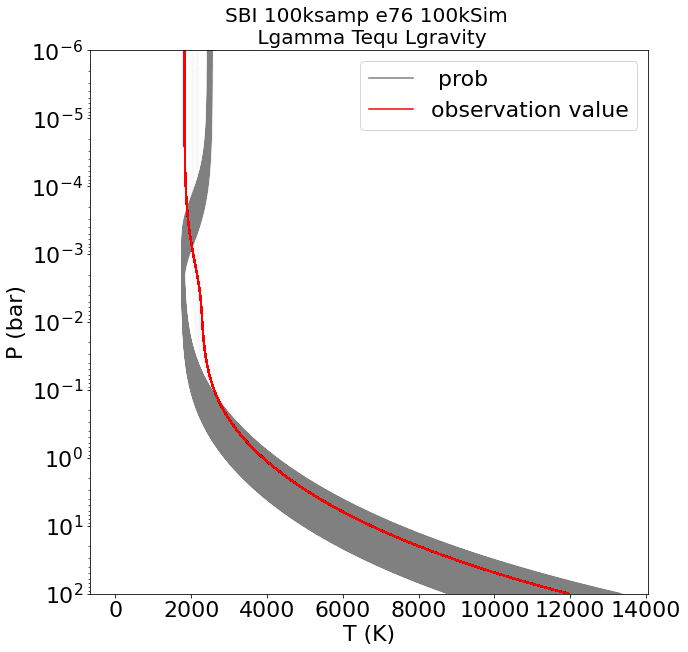

it takes: 21.709842709700265 min


In [16]:
# creating P-T profile for each - takes around 10 min
temp = []
cc=[]
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, figsize=(10,10))
plt.title('SBI 100ksamp e76 100kSim \n Lgamma Tequ Lgravity', fontsize=20)
start = time.time()
c2=0
c4=0

for i in np.random.randint(0,99999, 10000):  #np.arange(0,99999):  #
    index, log_gamma, T_equ, log_gravity = [df_samples[row][i] for row in df_samples]
    ind, lnprob = [df_lnprob[row][i] for row in df_lnprob]
    cc.append(color(lnprob)) 
    gamma = np.exp(log_gamma)
    gravity = np.exp(log_gravity)
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
       
    ax.plot(temperature, pressures, c='grey', alpha=0.002)
    ax.plot(temperature0, pressures, c= 'red', label = 'observation value' if c4 == 0 else "")
    c4+=1
    ax.plot([0], [0], c= 'grey', label = " prob " if c2 == 0 else "")
    c2+=0
#     plt.plot(temperature1, pressures, c= 'red')
#     plt.plot(temperature2, pressures, c= 'red')
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    temp.append(temperature)
#plt.savefig('/home/mvasist/results/SNRE/PT_profile/SBI_162ksamp_100kSim.png')
handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]  #, handles[3], handles[1]]
labels = [labels[1], labels[0]]  #, labels[3], labels[1]]
ax.legend(handles,labels)
# plt.legend()
plt.show()

end =time.time()
print('it takes: '+ str((end-start)/60) + ' min')

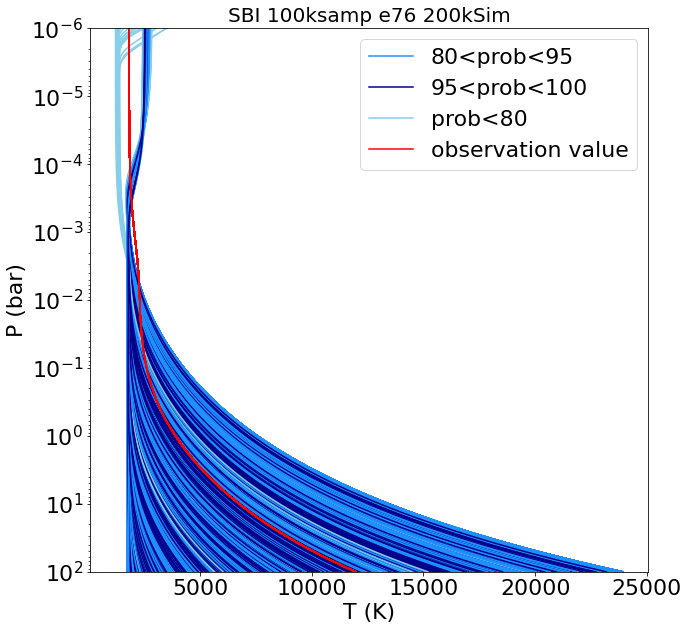

it takes: 14.197870341936747 min


In [14]:
# # creating P-T profile for each - takes around 10 min
# temp = []
# cc=[]
# fig, ax = plt.subplots(1, figsize=(10,10))
# plt.title('SBI 100ksamp e76 200kSim', fontsize=20)
# matplotlib.rcParams.update({'font.size': 22})
# start = time.time()
# c1=0
# c2=0
# c3=0
# c4=0

# for i in np.random.randint(0,99999, 10000):  #np.arange(0,99999):  #
#     index, log_gamma, T_int, T_equ = [df_samples[row][i] for row in df_samples]
#     ind, lnprob = [df_lnprob[row][i] for row in df_lnprob]
#     cc.append(color(lnprob)) 
#     gamma = np.exp(log_gamma)
#     temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
#     if ((color(lnprob)> 95) and (color(lnprob)<100)):
#         ax.plot(temperature, pressures, c='darkblue', label = "95<prob<100" if c1 == 0 else "") #viridis,jet,gray,parula(?),magma,plasma,inferno-plt.cm.inferno(color(lnprob))
#         c1+=1
#     elif ((color(lnprob)> 80) and (color(lnprob)<95)):
#         ax.plot(temperature, pressures, c='dodgerblue',label = "80<prob<95" if c2 == 0 else "") #if i == 0 else ""
#         c2+=1
#     elif (color(lnprob)< 80):
#         ax.plot(temperature, pressures, c='skyblue', label = "prob<80" if c3 == 0 else "")
#         c3+=1
#     ax.plot(temperature0, pressures, c= 'red', label = 'observation value' if c4 == 0 else "")
#     c4+=1
# #     plt.plot(temperature1, pressures, c= 'red')
# #     plt.plot(temperature2, pressures, c= 'red')
#     plt.yscale('log')
#     plt.ylim([1e2, 1e-6])
#     plt.xlabel('T (K)')
#     plt.ylabel('P (bar)')
#     temp.append(temperature)
# #plt.savefig('/home/mvasist/results/SNRE/PT_profile/SBI_162ksamp_100kSim.png')
# handles,labels = ax.get_legend_handles_labels()
# handles = [handles[2], handles[0], handles[3], handles[1]]
# labels = [labels[2], labels[0], labels[3], labels[1]]
# ax.legend(handles,labels)
# # plt.legend()
# plt.show()

# end =time.time()
# print('it takes: '+ str((end-start)/60) + ' min')

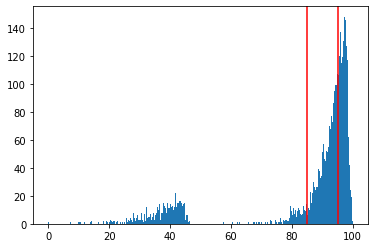

In [32]:
plt.hist(cc,bins=1000)
plt.axvline(95,c='r')
plt.axvline(85,c='r')


In [12]:
# len(np.where(np.sum(temp, axis= 1) == 0)[0])  # a lot of zeros 

In [80]:
np.shape(cc)
    

(10,)

In [35]:
abundances = {}

abundances['H2'] = 0.74* np.ones_like(pressures) # params[3].numpy() * np.ones_like(temperature)
abundances['He'] = 0.24* np.ones_like(pressures)  # params[4].numpy() * np.ones_like(temperature)
abundances['H2O'] = 0.001 * np.ones_like(pressures)
abundances['CO_all_iso'] = 0.01 * np.ones_like(pressures)
abundances['CO2'] = 0.00001 * np.ones_like(pressures)
abundances['CH4'] = 0.000001 * np.ones_like(pressures)
abundances['Na'] = 0.00001 * np.ones_like(pressures)
abundances['K'] = 0.000001 * np.ones_like(pressures)

MMW = rm.calc_MMW(abundances) * np.ones_like(pressures)



In [ ]:
# 1000 s from 200k sim takes 42 min

In [ ]:
import time

temp = []
f=[]
w=[]
fr=[]

start = time.time()
for ind, i in enumerate(np.random.randint(0,199999,10000)):
    print(ind,i)
    index, log_gamma, T_int, T_equ = [df_samples[row][i] for row in df_samples]
    gamma = np.exp(log_gamma)
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ) 
    temp.append(temperature)
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)
    wlen, flux_nu = nc.c/atmosphere.freq, atmosphere.flux/1e-6   
    
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 
    
    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                    data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])
            
        
    f.append(flux_nu)
    w.append(wlen)
    fr.append(flux_rebinned)
    
end= time.time()
print((end-start)/60, ' minutes')

    #wlen, flux_nu = nc.c/atmosphere.freq/1e-4/10000, atmosphere.flux/1e-6

#     plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6)

#     plt.xscale('log')
#     plt.xlabel('Wavelength (microns)')
#     plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
# plt.show()
# plt.clf()

0 105588
1 547
2 42990
3 46495
4 50206
5 89473
6 124403
7 156335
8 46585
9 123724
10 165569
11 170317
12 157492
13 3492
14 106491
15 186593
16 32737
17 4076
18 20382
19 70676
20 162624
21 77423
22 47248
23 113688
24 107532
25 85358
26 178431
27 94831
28 150657
29 58019
30 78686
31 125444
32 7122
33 92329
34 66094
35 125127
36 155118
37 196430
38 42629
39 187914
40 58589
41 43970
42 176344
43 189679
44 35326
45 43750
46 122842
47 49086
48 43198
49 122099
50 75980
51 77608
52 74971
53 180227
54 11202
55 33087
56 68984
57 123872
58 140095
59 127238
60 89033
61 135029
62 60933
63 147590
64 57080
65 75002
66 103576
67 35090
68 2228
69 97815
70 90634
71 70912
72 118174
73 155278
74 83733
75 96689
76 184601
77 163648
78 53833
79 47441
80 86447
81 51092
82 151556
83 46669
84 102836
85 112564
86 87525
87 30110
88 42243
89 84030
90 38056
91 44544
92 196407
93 88057
94 101204
95 197395
96 99604
97 92692
98 8259
99 37795
100 149825
101 175543
102 173040
103 7758
104 5601
105 103231
106 127626
107 

In [5]:
def similar(a): 
    a = np.stack(a, axis=0 )
    a=a.tolist()
    repeats ={}
    for h in range(len(a)):
        repeats[str(h)] = 1
    l=0
    e = []
    for i in range(len(a)):
        if (i not in e):
            for j in range(len(a)):
                if i==j : continue
                elif (a[i] == a[j]):
                    e.append(j)
                    repeats[str(i)] = repeats[str(i)] + 1
          
    d={}
    b = np.array(list(repeats.values())) 
    for k in np.where(b>1)[0]:
        d[str(k)] = repeats[str(k)]
        
    return d    

In [4]:
#saved spectra 

fr=[]

for i in range(1,50):
    f= pd.read_csv( '/home/mvasist/scripts/similar/similar' + str(i) +'.csv')   
    fr.append(f.values)

ff= np.vstack(fr)

df_fr = pd.DataFrame(ff)

In [5]:
df_fr

,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,1.0,1336.2277,1354.1688,1371.9349,1383.6597,1395.5970,1415.6469,1432.8326,1439.1323,1459.2786,...,2349.5195,2396.6526,2333.4400,2280.4570,2342.6382,2420.5154,2361.6990,2402.4463,2404.1072,2336.5833
1,2.0,1322.8792,1341.1868,1359.4097,1371.1803,1383.6842,1403.0994,1420.9141,1426.8541,1446.8872,...,2332.9548,2385.3608,2318.8997,2262.2170,2328.6191,2409.1116,2348.3890,2388.7640,2388.1045,2320.6743
2,3.0,1288.8436,1307.1754,1325.7930,1336.8802,1349.8930,1368.1029,1386.5901,1391.8885,1412.0753,...,2291.3975,2349.6184,2277.5684,2217.0780,2288.9832,2372.5352,2307.4424,2349.8674,2347.6343,2276.6409
3,4.0,1344.9836,1361.8258,1379.0802,1389.9235,1401.3785,1421.4680,1438.2137,1444.4426,1464.9926,...,2356.5537,2401.0867,2336.8810,2284.7761,2346.3188,2425.3254,2364.6711,2408.5090,2412.4807,2340.8284
4,5.0,1304.8038,1322.9563,1341.3931,1352.6243,1365.4667,1384.1257,1402.3845,1407.8883,1428.0759,...,2309.8350,2366.3540,2295.7495,2236.1050,2306.5464,2389.7680,2325.7990,2367.7788,2366.0590,2295.9463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195946,3995.0,2553.0188,2603.3552,2636.7239,2687.9856,2695.4143,2744.2940,2752.4675,2776.2136,2777.8794,...,4071.9353,4029.2075,4118.1846,4211.7440,4134.8520,3944.4512,4041.7349,3990.0464,3967.5823,4034.2680
195947,3996.0,2497.2770,2547.4580,2581.5352,2631.9705,2639.9968,2688.2078,2696.2230,2720.1858,2722.8620,...,3997.1733,3956.6836,4042.6240,4131.8604,4058.3474,3876.5588,3970.4321,3919.1418,3896.2458,3963.6228
195948,3997.0,2497.3662,2547.6973,2582.5068,2632.9229,2641.3323,2689.6433,2697.3901,2721.6567,2724.6113,...,4003.6680,3963.0537,4049.2024,4137.5703,4064.8870,3883.0344,3977.9120,3925.9607,3901.7810,3970.7812
195949,3998.0,2530.6060,2580.0898,2615.4140,2665.0860,2673.8577,2722.3410,2729.6553,2754.0613,2757.8440,...,4038.1155,3998.6230,4082.0415,4166.1753,4097.2450,3921.5305,4014.4040,3963.6702,3938.8123,4007.0850


In [8]:
np.shape(ff[:,1:])

(195951, 371)

In [9]:
print(len(ff[:,1:]))   #195951


195951


In [25]:
print(len(similar(ff[:,1:]).keys()))  #95976

95976


In [ ]:
aa  = similar(ff[:,1:])

In [ ]:
aa

In [27]:
fr_file = open("flux_rebinned.pkl", "wb")
pickle.dump(similar(ff[:,1:]), fr_file)
fr_file.close()

# a_file = open("data.pkl", "rb")
# output = pickle.load(a_file)
# print(output)

KeyboardInterrupt: 

In [ ]:
similar(ff[:,1:])  #takes 1 hr 20 min

In [1]:
# for N in range(1,51):
#     for ind, i in enumerate(4000*(N-1),4000*(N-1)+4000):
#         print(ind,i)

In [98]:
import json
a={ 345: 3, 45: 6, 56: 7}

In [100]:
with open('/home/mvasist/1.json', 'w') as f:
    json.dump(a, f)